### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import os

import datetime
from datetime import date, timedelta

from tqdm.notebook import tqdm

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
open_data_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'pal_val.csv'), index_col=0, parse_dates=True)
open_data_ts.head()

,n_trips
fecha_periodo,
2021-01-01 00:00:00,80.35
2021-01-01 00:15:00,65.04
2021-01-01 00:30:00,49.73
2021-01-01 00:45:00,34.42
2021-01-01 01:00:00,19.11


In [3]:
open_data_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3065 entries, 2021-01-01 00:00:00 to 2021-02-01 22:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   n_trips  3065 non-null   float64
dtypes: float64(1)
memory usage: 47.9 KB


In [4]:
def read_sensor_data():
    sensor_df = pd.read_csv(os.path.join('datasets', 'sensor','raw_sensor_data.csv'), index_col=0, parse_dates=True)
    sensor_df['total'] = sensor_df['20 30 40 50 65 80 90 100 110 120 130 140 150 160 236'.split()].sum(axis=1)
    sensor_df = sensor_df[sensor_df['total']>0]

    sensor_by_roadway= sensor_df[sensor_df['total']>0].groupby(['date','roadway'])['total'].sum().to_frame()
    sensor_by_roadway=sensor_by_roadway.reset_index(level=1)
    
    r1_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r1'].drop('roadway', axis=1)
    r2_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r2'].drop('roadway', axis=1)

    total_sensor= sensor_df['total'].groupby('date').sum('total').to_frame()

    return r1_series, r2_series, total_sensor

In [5]:
r1_ts, r2_ts, total_ts = read_sensor_data()

In [6]:
r1_ts.head()

,total
date,
2021-01-01 10:45:00,17.0
2021-01-01 11:00:00,36.0
2021-01-01 11:15:00,41.0
2021-01-01 11:30:00,58.0
2021-01-01 11:45:00,49.0


In [7]:
def generate_weather_ts_fn():
    dateparse = lambda x: datetime.datetime.strptime(x, '%d.%m.%Y %H:%M')

    weather_= pd.read_csv(os.path.join('datasets', 'weather', 'LEVD_weather.csv'),
                          sep=';', 
                          skiprows=6,
                          date_parser=dateparse,
                          usecols=[0,1],
                          squeeze=True,
                          error_bad_lines=False)
    
    weather_.columns = ['date', 'temp']
    weather_['date']= pd.to_datetime(weather_['date'], format='%d.%m.%Y %H:%M')
    weather_= weather_.set_index('date')
    weather_= weather_.resample('15min').interpolate('linear')
    return weather_

In [8]:
weather_ts=generate_weather_ts_fn()

/var/folders/kf/v1s43dsx3938g13xfjj52w9c0000gn/T/ipykernel_1307/3939737075.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  weather_ts=generate_weather_ts_fn()


In [9]:
weather_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3839 entries, 2020-12-30 00:00:00 to 2021-02-07 23:30:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    3839 non-null   float64
dtypes: float64(1)
memory usage: 60.0 KB


In [10]:
weather_ts.head()

,temp
date,
2020-12-30 00:00:00,0.0
2020-12-30 00:15:00,-0.5
2020-12-30 00:30:00,-1.0
2020-12-30 00:45:00,-1.5
2020-12-30 01:00:00,-2.0


# Visualización de datos

In [11]:
r1_ts.describe()

,total
count,1183.000000
mean,109.730347
std,75.146338
min,1.000000
25%,42.000000
50%,103.000000
75%,167.000000
max,346.000000


In [12]:
r2_ts.describe()

,total
count,1179.000000
mean,116.069550
std,76.207085
min,1.000000
25%,49.000000
50%,116.000000
75%,174.500000
max,342.000000


In [13]:
open_data_ts.describe()

,n_trips
count,3065.000000
mean,91.870509
std,83.147586
min,4.853000
25%,19.397375
50%,65.661000
75%,140.363500
max,410.753000


# Preprocesado de datos

### Cointegration test

Dataframe with the scaled trips

In [14]:
trips_df = r2_ts.copy()
trips_df['open_data_trips']= open_data_ts['n_trips']
#trips_df['total_r2']= r2_ts['total']
#trips_df['temp']= weather_ts['temp']
trips_df= trips_df.reset_index(drop=True)
trips_df= trips_df.fillna(method='ffill')
trips_df.head()

,total,open_data_trips
0,16.0,18.03200
1,61.0,20.28700
2,63.0,25.59175
3,58.0,30.89650
4,57.0,36.20125


In [15]:
trips_df.tail()

,total,open_data_trips
1174,44.0,10.539083
1175,1.0,11.041667
1176,2.0,11.544250
1177,1.0,12.549417
1178,7.0,13.052000


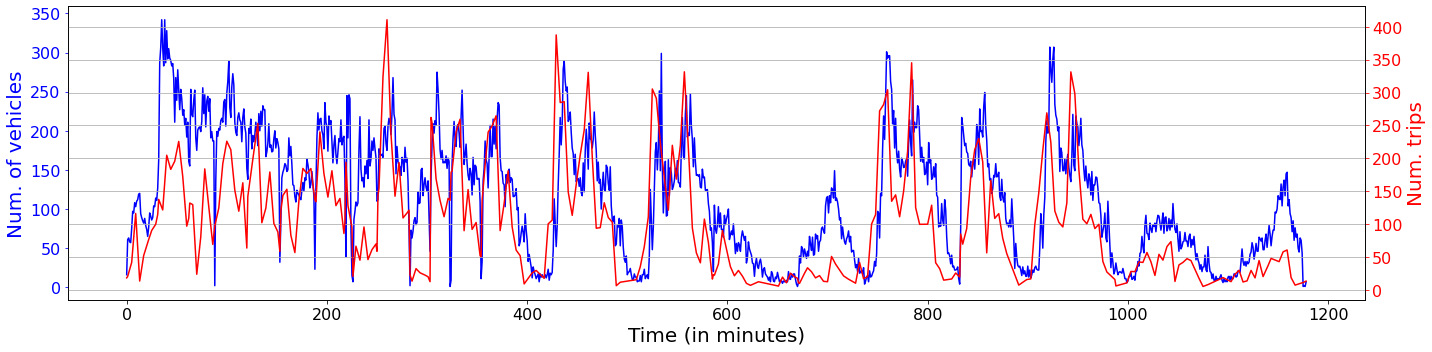

In [16]:
def plot_sensor_human_flow(sensor_df, subflow, figname):
    
        ax=sensor_df.reset_index(drop=True).plot(color='blue',figsize=(20,5))
        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))

        subflow.reset_index(drop=True).plot(ax=ax2, grid=True, color='red')

        ax.set_ylabel('Num. of vehicles', fontsize=20)
        ax.set_xlabel('Time (in minutes)', fontsize=20)
        ax2.set_ylabel('Num. trips', fontsize=20)
        ax.yaxis.label.set_color('blue')
        ax2.yaxis.label.set_color('red')

        ax.tick_params(axis='y', colors='blue', labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        ax2.tick_params(axis='y', colors='red', labelsize=16)
        
        
        plt.tight_layout()
        plt.savefig(os.path.join('figs', f'{figname}.png'))

plot_sensor_human_flow(trips_df['total'], trips_df['open_data_trips'],'inter_city_level_timeseries')

In [17]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,7)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    print(out.trace_stat)

In [18]:
cointegration_test(trips_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
total  ::  74.05     > 12.3212   =>   True
open_data_trips ::  6.01      > 4.1296    =>   True
[74.04573055  6.00634093]


### Granger test

In [19]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(trips_df, variables = trips_df.columns)

,total_x,open_data_trips_x
total_y,1.0,0.0
open_data_trips_y,0.0,1.0


In [23]:
grangercausalitytests(trips_df[['total','open_data_trips']], 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=131.3444, p=0.0000  , df_denom=1175, df_num=1
ssr based chi2 test:   chi2=131.6797, p=0.0000  , df=1
likelihood ratio test: chi2=124.8262, p=0.0000  , df=1
parameter F test:         F=131.3444, p=0.0000  , df_denom=1175, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=70.3290 , p=0.0000  , df_denom=1172, df_num=2
ssr based chi2 test:   chi2=141.2581, p=0.0000  , df=2
likelihood ratio test: chi2=133.4040, p=0.0000  , df=2
parameter F test:         F=70.3290 , p=0.0000  , df_denom=1172, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=49.8451 , p=0.0000  , df_denom=1169, df_num=3
ssr based chi2 test:   chi2=150.4308, p=0.0000  , df=3
likelihood ratio test: chi2=141.5585, p=0.0000  , df=3
parameter F test:         F=49.8451 , p=0.0000  , df_denom=1169, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=39.7218 , p=0.

{1: ({'ssr_ftest': (131.34439776143512, 6.69524829015567e-29, 1175.0, 1),
   'ssr_chi2test': (131.67974515997497, 1.758123990217108e-30, 1),
   'lrtest': (124.82624314260283, 5.55521275831254e-29, 1),
   'params_ftest': (131.3443977614871, 6.695248289998681e-29, 1175.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (70.32898913237089, 1.42808180806996e-29, 1172.0, 2),
   'ssr_chi2test': (141.25805496382344, 2.119352040947551e-31, 2),
   'lrtest': (133.4039829993617, 1.0757049317630493e-29, 2),
   'params_ftest': (70.32898913237045, 1.4280818080705893e-29, 1172.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (49.845128176417795, 2.5718982942117446e-30, 1169.0, 3),
   'ssr_chi2test': (150.43080599350043, 2.1273195507992848e-32, 3),
   'lrtest': (141.55850796105915, 1.7434307319934215e-30, 3),
   'params_ftest': (49.84512817641657, 2.5718982942158382e-30, 1169.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 

In [22]:
grangercausalitytests(trips_df[['open_data_trips','total']], 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=36.5953 , p=0.0000  , df_denom=1175, df_num=1
ssr based chi2 test:   chi2=36.6887 , p=0.0000  , df=1
likelihood ratio test: chi2=36.1290 , p=0.0000  , df=1
parameter F test:         F=36.5953 , p=0.0000  , df_denom=1175, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5592  , p=0.0778  , df_denom=1172, df_num=2
ssr based chi2 test:   chi2=5.1402  , p=0.0765  , df=2
likelihood ratio test: chi2=5.1290  , p=0.0770  , df=2
parameter F test:         F=2.5592  , p=0.0778  , df_denom=1172, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4545  , p=0.0040  , df_denom=1169, df_num=3
ssr based chi2 test:   chi2=13.4436 , p=0.0038  , df=3
likelihood ratio test: chi2=13.3674 , p=0.0039  , df=3
parameter F test:         F=4.4545  , p=0.0040  , df_denom=1169, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6171  , p=0.

{1: ({'ssr_ftest': (36.59526656929061, 1.951364066678453e-09, 1175.0, 1),
   'ssr_chi2test': (36.68870129244625, 1.3858031047066205e-09, 1),
   'lrtest': (36.128960560585256, 1.8468168286771018e-09, 1),
   'params_ftest': (36.5952665692904, 1.951364066678592e-09, 1175.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.55919111233844, 0.07779959498484003, 1172.0, 2),
   'ssr_chi2test': (5.140218326317994, 0.07652719101800246, 2),
   'lrtest': (5.129026665801575, 0.07695662458717503, 2),
   'params_ftest': (2.5591911123384543, 0.07779959498484003, 1172.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.454536017796622, 0.0040430744476535755, 1169.0, 3),
   'ssr_chi2test': (13.443629658499983, 0.003769152660894744, 3),
   'lrtest': (13.367368812705536, 0.0039058966499443373, 3),
   'params_ftest': (4.454536017796452, 0.004043074447654872, 1169.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

### Check stationarity

In [19]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [20]:
adfuller_test(trips_df['total'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5896
 No. Lags Chosen       = 9
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


In [21]:
adfuller_test(trips_df['open_data_trips'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5405
 No. Lags Chosen       = 22
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


In [22]:
#adfuller_test(trips_df['temp'])

In [23]:
#adfuller_test(trips_df['total_r2'])

### Select order for VAR Model

In [24]:
model = VAR(trips_df)

In [25]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,16.87,16.88,2.120e+07,16.87
1,12.30,12.32,2.188e+05,12.31
2,12.02,12.06,1.652e+05,12.03
3,11.98,12.04*,1.589e+05,12.00*
4,11.97,12.05,1.578e+05,12.00
5,11.97,12.06,1.574e+05,12.00
6,11.97,12.08,1.576e+05,12.01
7,11.97,12.10,1.572e+05,12.01
8,11.97,12.12,1.578e+05,12.02
9,11.96*,12.13,1.566e+05*,12.02


Best lag is set to 7 days

In [26]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Feb, 2022
Time:                     17:54:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.0927
Nobs:                     1172.00    HQIC:                   12.0120
Log likelihood:          -10306.3    FPE:                    156851.
AIC:                      11.9630    Det(Omega_mle):         152912.
--------------------------------------------------------------------
Results for equation total
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      3.133890         1.504358            2.083           0.037
L1.total                   0.655812         0.029332           22.359           0.000
L1.open_data_trips         0.327216     

In [27]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)


for col, val in zip(trips_df.columns, out):
    print(adjust(col), ':', round(val, 2))

total  : 2.01
open_data_trips : 2.0


### Forecast test

In [28]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides) 

def mape_fn(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid, y_hat):
    metrics= {}
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for i in range(y_valid.shape[1]):
        mae = mean_absolute_error(y_valid[:,i], y_hat[:,i])
        mse = mean_squared_error(y_valid[:,i], y_hat[:,i])
        rmse= mean_squared_error(y_valid[:,i], y_hat[:,i], squared = False)
        cvrmse =  rmse/np.mean(y_valid[:,i])*100 # it is a percentage
        mape = mape_fn(y_valid[:,i], y_hat[:,i])

        metrics_i = {}
        
        metrics_i['mae']= mae
        metrics_global['mae'].append(mae)
        
        metrics_i['mse']= mse
        metrics_global['mse'].append(mse)
        
        metrics_i['rmse']= rmse
        metrics_global['rmse'].append(rmse)
        
        metrics_i['cvrmse']= cvrmse
        metrics_global['cvrmse'].append(cvrmse)
        
        metrics_i['mape']= mape
        metrics_global['mape'].append(mape)
        
        metrics[i]= metrics_i

    metrics_global['mae']= np.mean(metrics_global['mae'])
    metrics_global['mse']= np.mean(metrics_global['mse'])
    metrics_global['rmse']= np.mean(metrics_global['rmse'])
    metrics_global['cvrmse']= np.mean(metrics_global['cvrmse'])
    metrics_global['mape']= np.mean(metrics_global['mape'])
    
    metrics['global']= metrics_global
    
    return metrics

def compute_metrics_as_dataframe_fn(y_valid, y_hat):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for i in range(y_valid.shape[1]):
        mae = mean_absolute_error(y_valid[:,i], y_hat[:,i])
        mse = mean_squared_error(y_valid[:,i], y_hat[:,i])
        rmse= mean_squared_error(y_valid[:,i], y_hat[:,i], squared = False)
        cvrmse =  rmse/np.mean(y_valid[:,i])*100 # it is a percentage
        mape = mape_fn(y_valid[:,i], y_hat[:,i])

        metrics.append((i, mae, mse, rmse, cvrmse, mape))
        
    
    metrics_df = pd.DataFrame.from_records(metrics, columns='T MAE MSE RMSE CVRMSE MAPE'.split())
    metrics_df = metrics_df.set_index('T')
    metrics_df.loc['global']= metrics_df.mean(axis=0)
    
    return metrics_df

In [29]:
ine_hat = []
n_steps_ahead = 8 # 2 hours
n_lags = 7
lr= 0.7 # learning rate
training_size= int(trips_df.shape[0]* lr)
for i in range(training_size, trips_df.shape[0]-n_steps_ahead+1):
    X= trips_df.iloc[:i].values
    
    model = VAR(X)
    model_fitted = model.fit(n_lags)

    y_hat = model_fitted.forecast(y=X[-n_lags:], steps=n_steps_ahead)
    
    ine_hat.append(y_hat[:,1])

ine_true = trips_df.iloc[training_size:]['open_data_trips'].values
ine_hat= np.array(ine_hat)    

var_metrics_df = compute_metrics_as_dataframe_fn(rolling_window(ine_true, n_steps_ahead), ine_hat)
var_metrics_df

,MAE,MSE,RMSE,CVRMSE,MAPE
T,,,,,
0,5.252164,71.479086,8.454531,12.401820,14.843720
1,11.174957,267.056506,16.341864,23.980841,33.925449
2,17.459367,598.305140,24.460277,35.910696,57.049113
3,23.769897,1047.368777,32.363077,47.538411,82.075296
4,29.402481,1500.858959,38.740921,56.941644,105.031301
5,34.367411,1948.152632,44.137882,64.908169,126.125685
6,38.639066,2378.728965,48.772215,71.753227,145.870783
7,42.352036,2785.911958,52.781739,77.677677,164.223226
global,25.302172,1324.732753,33.256563,48.889061,91.143072


In [ ]:
var_metrics_df.to_csv(os.path.join('results', 'inter_city_level_var_metrics.csv'))

### Generate plot

In [30]:
n_samples_train = int(trips_df.shape[0]*0.8)
n_samples_train

947

In [31]:
X= trips_df.iloc[:n_samples_train]
model = VAR(X.iloc[:-7])
model_fitted = model.fit(7)

In [32]:
ine_true_train = []
ine_hat_train = []
look_back=7
for i in range(look_back, n_samples_train):
    X= trips_df.iloc[i-look_back:i]
    X_differenced = X.dropna()
    
    y =trips_df.iloc[i+1]
    y_true_ine = y[1]#[v[1] for v in y.values]
    
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:], steps=1)
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+1].index, columns=trips_df.columns + '_forecast')

    #columns = trips_df.columns
    #for col in columns:  
    #    df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    y_hat_ine = list(df_forecast['open_data_trips_forecast'].values)
    #print(y_true_ine, y_hat_ine)
    ine_true_train = ine_true_train + y_true_ine
    ine_hat_train = ine_hat_train + y_hat_ine

In [33]:
ine_true_test = []
ine_hat_test = []
look_back=7
n_steps_ahead = 8 # 2 hours
for i in range(n_samples_train, trips_df.shape[0]-look_back):
    X= trips_df.iloc[i-look_back:i]
    X_differenced = X.dropna()
    
    y =trips_df.iloc[i+1]
    y_true_ine = y[1]#[v[1] for v in y.values]
    
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:], steps=n_steps_ahead)
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+1].index, columns=trips_df.columns + '_forecast')
    
    #columns = trips_df.columns
    #for col in columns:  
    #    df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    y_hat_ine = list(df_forecast['open_data_trips_forecast'].values)
    #print(y_true_ine, y_hat_ine)
    ine_true_test = ine_true_test + y_true_ine
    ine_hat_test = ine_hat_test + y_hat_ine

ValueError: Shape of passed values is (8, 2), indices imply (1, 2)

In [ ]:
ine_trips = trips_df['open_data_trips'].astype(float)

In [ ]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(ine_trips)
trainPredictPlot[:] = np.nan
#trainPredictPlot[look_back+1:n_samples_train+1] = ine_hat_train
trainPredictPlot[:n_samples_train-look_back] = ine_hat_train
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(ine_trips)
testPredictPlot[:] = np.nan
#testPredictPlot[n_samples_train+1:len(ine_trips)-look_back+1] = ine_hat_test
testPredictPlot[n_samples_train-1:len(ine_trips)-(look_back)-1] = ine_hat_test
# plot baseline and predictions
plt.plot(trips_df['open_data_trips'].values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Raw trips', 'Training data prediction', 'Test data prediction'), loc = 'upper left')
plt.grid(True)
#plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Time", fontsize = 10)
plt.ylabel("Number of trips", fontsize = 10)
plt.tight_layout()
plt.savefig('var_ine_twt_pred.png')
plt.show()

In [ ]:
print("That's all folks!")